In [1]:
# !pip install transformers
# !pip install keras_nlp
# !pip install datasets
# !pip install huggingface-hub huggingface_hub
# !pip install nltk
# !pip install rouge-score rouge
# !pip install evaluate
# !apt install git-lfs

In [2]:
!git config --global user.email "oabass7@gmail.com"
!git config --global user.name "Jammal"

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from datasets import load_dataset, load_metric, load_from_disk
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, AdamWeightDecay, create_optimizer 
from transformers.keras_callbacks import  KerasMetricCallback
import evaluate
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

# Only log error messages
import logging
tf.get_logger().setLevel(logging.ERROR)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading the dataset

### About Dataset
[BIGPATENT](https://huggingface.co/datasets/big_patent), consisting of 1.3 million records of U.S. patent documents along with human written abstractive summaries. Each US patent application is filed under a Cooperative Patent Classification (CPC) code. There are nine such classification categories:

* a: Human Necessities
* b: Performing Operations; Transporting
* c: Chemistry; Metallurgy
* **d: Textiles; Paper**
* e: Fixed Constructions
* f: Mechanical Engineering; Lightning; Heating; Weapons; Blasting
* g: Physics
* h: Electricity
* y: General tagging of new or cross-sectional technology

I will be working with 1 out of the 9 classification categories due to low compute unit.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# df = load_dataset("big_patent", "d")

In [6]:
# saving the data
# df.to_csv('/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/d.csv', index=False)
# df.save_to_disk('/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/d_dataset')

In [7]:
df = load_from_disk('/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/d_dataset')
print(df)

DatasetDict({
    train: Dataset({
        features: ['description', 'abstract'],
        num_rows: 10164
    })
    validation: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
    test: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
})


In [8]:
df['train'] = df['train'].shuffle(seed=42).select(range(1000))

In [9]:
print(df)

DatasetDict({
    train: Dataset({
        features: ['description', 'abstract'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
    test: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
})


### Define Certain Variables

In [10]:
# Maximum length of the input to the model
MAX_INPUT_LENGTH = 1024  

# Minimum length of the output by the model
MIN_TARGET_LENGTH = 5  
# Maximum length of the output by the model
MAX_TARGET_LENGTH = 512 

# Batch-size for training our model
BATCH_SIZE = 16

## T5 Model

#### Data preprocessing

In [11]:
MODEL_CHECKPOINT = "t5-small"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

if MODEL_CHECKPOINT in ["t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

In [12]:
def preprocess_function(examples):
    inputs = [prefix + inp for inp in examples["description"]]
    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LENGTH, truncation=True)
    targets = examples["abstract"]

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=MAX_TARGET_LENGTH, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [13]:
tokenized_df = df.map(preprocess_function, batched=True)

In [14]:
tokenized_df["train"]

Dataset({
    features: ['description', 'abstract', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})

### Fine-tuning the Model

In [15]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [16]:
# pushing the model to tensorflow hub
model_name = MODEL_CHECKPOINT.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-Big-Patent"

In [17]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")
generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", pad_to_multiple_of=128)

In [18]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_df["train"],
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_df["validation"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=data_collator,
)

tf_generation_set = model.prepare_tf_dataset(
    tokenized_df["validation"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=generation_data_collator
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


### Compiling the Model

In [19]:
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01) 
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


### Evaluate the Model

In [20]:
metric = load_metric("rouge")

def metric_fn(eval_predictions):
    predictions, labels = eval_predictions
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    for label in labels:
        label[label < 0] = tokenizer.pad_token_id  # Replace masked label tokens
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Rouge expects a newline after each sentence
    decoded_predictions = [
        "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
    ]
    decoded_labels = [
        "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
    ]
    result = metric.compute(
        predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
    )
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    # Add mean generated length
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
    ]
    result["gen_len"] = np.mean(prediction_lens)

    return result

metric_callback = KerasMetricCallback(
    metric_fn, eval_dataset=tf_generation_set, predict_with_generate=True, use_xla_generation=True
)

callbacks = [metric_callback]

In [21]:
# from transformers.keras_callbacks import PushToHubCallback, KerasMetricCallback
# from tensorflow.keras.callbacks import TensorBoard

# tensorboard_callback = TensorBoard(log_dir="./summarization_model_save/logs")

# push_to_hub_callback = PushToHubCallback(
#     output_dir="./summarization_model_save",
#     tokenizer=tokenizer,
#     hub_model_id=push_to_hub_model_id,
# )

### Train the Model

In [22]:
history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=15, callbacks=callbacks)

Epoch 1/15
62/62 [==============================] - 1222s 19s/step - loss: 3.7320 - val_loss: 2.9733 - rouge1: 16.2409 - rouge2: 6.4803 - rougeL: 13.1756 - rougeLsum: 14.2942 - gen_len: 19.0000
Epoch 2/15
62/62 [==============================] - 1177s 19s/step - loss: 3.0677 - val_loss: 2.7876 - rouge1: 16.4855 - rouge2: 6.8046 - rougeL: 13.2438 - rougeLsum: 14.5530 - gen_len: 19.0000
Epoch 3/15
62/62 [==============================] - 1179s 19s/step - loss: 2.9249 - val_loss: 2.6938 - rouge1: 16.5255 - rouge2: 6.7694 - rougeL: 13.2579 - rougeLsum: 14.5214 - gen_len: 19.0000
Epoch 4/15
62/62 [==============================] - 1173s 19s/step - loss: 2.8336 - val_loss: 2.6325 - rouge1: 16.9132 - rouge2: 7.2116 - rougeL: 13.5918 - rougeLsum: 14.8494 - gen_len: 19.0000
Epoch 5/15
62/62 [==============================] - 1175s 19s/step - loss: 2.7816 - val_loss: 2.5908 - rouge1: 17.2720 - rouge2: 7.4521 - rougeL: 13.8003 - rougeLsum: 15.2022 - gen_len: 19.0000
Epoch 6/15
62/62 [============

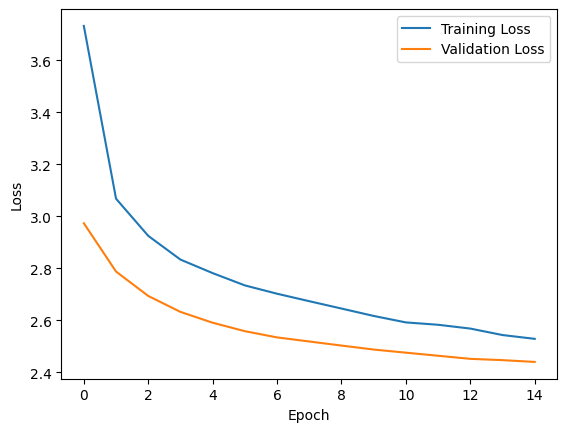

In [23]:
# Plot the metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Save the model in SavedModel format
model.save("my_model", save_format="tf")

## MT5 Model

## BART Model

## PEGASUS Model

## GP2 Model